## Home Loan Approval/Denial

This project aims to develop a machine learning model that can predict the approval or denial of home mortgage applications using the U.S. Home Mortgage Disclosure Act (HMDA) dataset. Individuals can utilize this model as a preliminary assessment tool before formally applying for a mortgage, while lenders can leverage it for initial screening purposes. The ultimate goal is to empower both parties with information that facilitates informed decision-making in the mortgage application process.

In this project I will be using the 2020-to-2022 data of the SF East Bay counties, namely **Alameda County** and **Contra Costa County** (California, US). The dataset can be downloaded [here](https://ffiec.cfpb.gov/data-browser/data/2022?category=states&items=CA), and [here](https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields) is its documentation.

In [1]:
from io import StringIO
import requests
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

### Auxiliary functions

In [3]:
def test_cuts(x, col, thr, n=4):
    """
    This function display the data grouped in bins.
    """
    display(pd.cut(x[x[col] < thr][col], bins=n).value_counts(sort=False, dropna=False))
    display(pd.qcut(x[x[col] < thr][col], q=n).value_counts(sort=False, dropna=False))


def download_datasets():
    counties = ",".join(["06001", "06013"])  # Alameda, Contra Costa
    actions = ",".join(["1", "3"])  # Loan originated, Application denied
    dfs = []
    print("Downloading...")
    for year in [2020, 2021, 2022]:
        print(f"- year {year}")
        req = requests.get(
            f"https://ffiec.cfpb.gov/v2/data-browser-api/view/csv?years={year}&counties={counties}&actions_taken={actions}"
        )
        df = pd.read_csv(StringIO(req.text))
        dfs.append(df)
    return dfs


def open_dataset(filepath):
    file = Path(filepath)
    if file.exists() and file.stat().st_size > 1e6:
        df = pd.read_csv(filepath)
    else:
        dfs = download_datasets()
        df = pd.concat(dfs).drop_duplicates().reset_index(drop=True)
        df.to_csv(filepath, index=False)
    return df

### Loading the raw data

Using the auxiliary functions defined above the data be loaded from the filesystem or downloaded and saved in case the file does not exist. The data is downloaded using the [FFIEC Data Browser API](https://ffiec.cfpb.gov/documentation/api/data-browser/).

In [4]:
orig_df = open_dataset("../../data-hdma-eastbay-2020-2022.csv")

/tmp/ipykernel_294422/1079481606.py:27: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


The dataset contains 492584 entries and 99 columns, and the description of the features is [documented here](https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields).

Below is the info for all the columns in the raw dataset. We can see that multiple columns have a huge amount of null values, mostly the ones that are related to questions with multiple possible answers, such as race, etchnicity (of both the applicant and the co-applicant, if there is one), and the application denial reason. A few columns also should be numbers-only but contain a mix of number and strings, and will be properly converted. Also, quite a few of the numerical features are actually encoded categorical features, and they will be translated into strings using the documentation.

The main outcome of the dataset is in the `action_taken` column. All the possible values are:

- 1 - Loan originated
- 2 - Application approved but not accepted
- 3 - Application denied
- 4 - Application withdrawn by applicant
- 5 - File closed for incompleteness
- 6 - Purchased loan
- 7 - Preapproval request denied
- 8 - Preapproval request approved but not accepted

Since the main focus here is to screen through applications that are either *approved* or *denied*, I only fetch values `1` (Loan originated, application was approved) and `3` (application denied).

In [5]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492584 entries, 0 to 492583
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             492584 non-null  int64  
 1   lei                                       492584 non-null  object 
 2   derived_msa-md                            492584 non-null  int64  
 3   state_code                                492511 non-null  object 
 4   county_code                               492584 non-null  int64  
 5   census_tract                              492399 non-null  float64
 6   conforming_loan_limit                     490488 non-null  object 
 7   derived_loan_product_type                 492584 non-null  object 
 8   derived_dwelling_category                 492584 non-null  object 
 9   derived_ethnicity                         492584 non-null  object 
 10  derived_race        

In [6]:
orig_df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2020,AD6GFRVSDT01YPT1CS68,36084,CA,6013,6.013345e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,5178,63.25,119200,130,1012,1254,31
1,2020,AD6GFRVSDT01YPT1CS68,36084,CA,6001,6.001445e+09,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4341,77.72,119200,117,1114,1357,31
2,2020,AD6GFRVSDT01YPT1CS68,36084,CA,6013,6.013392e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,3116,90.89,119200,150,705,763,10
3,2020,AD6GFRVSDT01YPT1CS68,36084,CA,6001,6.001442e+09,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4811,78.07,119200,88,838,1076,45
4,2020,AD6GFRVSDT01YPT1CS68,36084,CA,6001,6.001428e+09,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4924,42.42,119200,118,1028,1664,76


In [7]:
orig_df.tail()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
492579,2022,5493000YNV8IX4VD3X12,36084,CA,6013,6.013355e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Hispanic or Latino,...,NaN,NaN,NaN,5793,66.80,142800,108,1448,1709,32
492580,2022,5493000YNV8IX4VD3X12,36084,CA,6013,6.013335e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Hispanic or Latino,...,NaN,NaN,NaN,3463,48.46,142800,94,816,1235,66
492581,2022,5493000YNV8IX4VD3X12,36084,CA,6013,6.013355e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Not Hispanic or Latino,...,7.0,NaN,NaN,4434,82.68,142800,79,808,1205,32
492582,2022,5493000YNV8IX4VD3X12,36084,CA,6013,6.013355e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Ethnicity Not Available,...,NaN,NaN,NaN,5000,26.24,142800,125,1503,1660,46
492583,2022,5493000YNV8IX4VD3X12,36084,CA,6001,6.001451e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Ethnicity Not Available,...,NaN,NaN,NaN,8901,82.44,142800,122,814,1290,28


### Cleaning the data

#### First-round: Simplifying

My first step here is to do first-round of data cleaning, mostly simplifying the data by renaming some features and dropping the ones that will not be used.

Dropping:

- `activity_year`, `state_code`, `county_code`, `derived_msa-md`: constants, codes
- `lei`: I will not differentiate between the financial institutions
- `aus-*`: The automated underwriting system(s) (AUS) used by the financial institution to evaluate the application
- `_observed`: whether the information was collected on the basis of visual observation or surname
- `census_tract`
- `preapproval`: all pre-approved applications are approved

Simplifying:

- `denial-reason-*`: columns are directly related to the `Denied` applications and will not be used in the training, but are useful to analyze before modeling. I will join all reasons in one feature.
- `[co-]applicant_race-*` and `[co-]applicant_ethnicity-*`: will keep only option 1 with broader groups

Renaming:

- `action_taken` to `application_outcome`

Removing:

- all rows with `Exempt`

In [8]:
unused_columns = [
    *[x for x in orig_df.columns if x.startswith("aus-")],
    *[x for x in orig_df.columns if x.endswith("observed")],
    *[x for x in orig_df.columns if x.endswith("_credit_score_type")],
    # *[x for x in orig_df.columns if x.endswith("derived")],
    "activity_year",
    "state_code",
    "county_code",
    "derived_msa-md",
    "lei",
    "census_tract",
    "preapproval",
    "submission_of_application",
    "manufactured_home_secured_property_type",
    "manufactured_home_land_property_interest",
    "other_nonamortizing_features",
    "negative_amortization",
    "initially_payable_to_institution",
    "ffiec_msa_md_median_family_income",
]

df = orig_df.drop(unused_columns, axis=1)
df = df[df != "Exempt"]
df = df.rename(
    columns={
        "action_taken": "application_outcome",
        "co-applicant_sex": "coapplicant_sex",
        "co-applicant_age": "coapplicant_age",
    }
)

# joining all denial_reasons
df["denial_reason"] = (
    df[[x for x in df.columns if x.startswith("denial_reason-")]]
    .replace(
        {
            1: "Debt-to-income ratio",
            2: "Employment history",
            3: "Credit history",
            4: "Collateral",
            5: "Insufficient cash",
            6: "Unverifiable information",
            7: "Credit application incomplete",
            8: "Mortgage insurance denied",
            9: "Other",
            10: "not_applicable",
        }
    )
    .apply(
        lambda x: ";".join([str(reason) for reason in x if pd.notnull(reason)]), axis=1
    )
)
df = df.drop([x for x in df.columns if x.startswith("denial_reason-")], axis=1)

# applicant race
df["applicant_race"] = (
    df[["applicant_race-1"]]
    .map(lambda x: int(str(int(x))[:1]) if pd.notnull(x) else np.nan)
    .replace(
        {
            1: "NA/PI",
            2: "Asian",
            3: "Black",
            4: "NA/PI",
            5: "White",
            6: "not_provided",
            7: "not_applicable",
        }
    )
)
df = df.drop([x for x in df.columns if x.startswith("applicant_race-")], axis=1)

# co-applicant race
df["coapplicant_race"] = (
    df[["co-applicant_race-1"]]
    .map(lambda x: int(str(int(x))[:1]) if pd.notnull(x) else np.nan)
    .replace(
        {
            1: "NA/PI",
            2: "Asian",
            3: "Black",
            4: "NA/PI",
            5: "White",
            6: "not_provided",
            7: "not_applicable",
            8: "no_coapplicant",
        }
    )
)
df = df.drop([x for x in df.columns if x.startswith("co-applicant_race-")], axis=1)

# applicant ethnicity
df["applicant_ethnicity"] = (
    df[["applicant_ethnicity-1"]]
    .map(lambda x: int(str(int(x))[:1]) if pd.notnull(x) else np.nan)
    .replace(
        {
            1: "Hispanic/Latino",
            2: "Not Hispanic/Latino",
            3: "not_provided",
            4: "not_applicable",
        }
    )
)
df = df.drop([x for x in df.columns if x.startswith("applicant_ethnicity-")], axis=1)

# co-applicant ethnicity
df["coapplicant_ethnicity"] = (
    df[["co-applicant_ethnicity-1"]]
    .map(lambda x: int(str(int(x))[:1]) if pd.notnull(x) else np.nan)
    .replace(
        {
            1: "Hispanic/Latino",
            2: "Not Hispanic/Latino",
            3: "not_provided",
            4: "not_applicable",
            5: "no_coapplicant",
        }
    )
)
df = df.drop([x for x in df.columns if x.startswith("co-applicant_ethnicity-")], axis=1)

print(df.shape)

(492584, 53)


### Second-round: Analyse column counts and map to new variables

Here I will go column by column checking the distribution of values and mapping them to better values. This will also be used to filter and remove rows in order to simplify the dataset.

#### Target feature: application outcome

In [9]:
# 1 - Loan originated
# 3 - Application denied
display(df["application_outcome"].value_counts(dropna=False))

application_outcome
1    422694
3     69890
Name: count, dtype: int64

In [10]:
# Target feature
df["application_outcome"] = df["application_outcome"].map({1: "Approved", 3: "Denied"})
display(df["application_outcome"].value_counts(dropna=False))

application_outcome
Approved    422694
Denied       69890
Name: count, dtype: int64

application_outcome
Approved    0.858116
Denied      0.141884
Name: proportion, dtype: float64


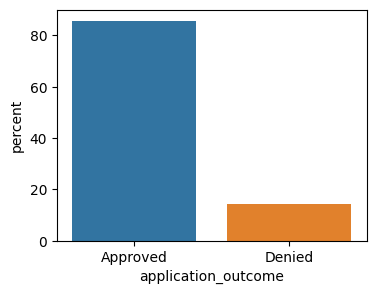

In [11]:
print(f'{df["application_outcome"].value_counts(normalize=True)}')

f, ax = plt.subplots(figsize=(4, 3))
sns.countplot(
    df, x="application_outcome", stat="percent", hue="application_outcome", ax=ax
)
plt.show()

#### Age of applicant and co-applicant

In [12]:
display(df["applicant_age"].value_counts(dropna=False))

applicant_age
35-44    141339
45-54    125543
55-64     88058
25-34     66758
65-74     46754
>74       18717
8888       3388
<25        2027
Name: count, dtype: int64

In [13]:
df['coapplicant_age'] = df["coapplicant_age"].replace({'9999': 'no_coapplicant', '8888': np.nan})
df = df.dropna(axis=0, subset='coapplicant_age')

#### Sex of applicant and co-applicant

In [14]:
# 1 - Male
# 2 - Female
# 3 - Information not provided by applicant in mail, internet, or telephone application
# 4 - Not applicable
# 6 - Applicant selected both male and female
display(df["applicant_sex"].value_counts(dropna=False))

applicant_sex
1    295874
2    142442
3     49159
4      2384
6       309
Name: count, dtype: int64

In [15]:
# Selecting Male (1), Female (2), not_provided (3); dropping the rest
df["applicant_sex"] = df["applicant_sex"].map(
    {1: "Male", 2: "Female", 3: "not_provided"}
)
df = df.dropna(axis=0, subset="applicant_sex")
display(df["applicant_sex"].value_counts(dropna=False))

applicant_sex
Male            295874
Female          142442
not_provided     49159
Name: count, dtype: int64

In [16]:
# 1 - Male
# 2 - Female
# 3 - Information not provided by applicant in mail, internet, or telephone application
# 4 - Not applicable
# 5 - no co-applicant
# 6 - Applicant selected both male and female
display(df["coapplicant_sex"].value_counts())

coapplicant_sex
5    244194
2    156945
1     58526
3     27200
4       472
6       138
Name: count, dtype: int64

In [17]:
# Selecting Male (1), Female (2), not_provided (3), no_coapplicant (5)
df["coapplicant_sex"] = df["coapplicant_sex"].map(
    {1: "Male", 2: "Female", 3: "not_provided", 5: "no_coapplicant"}
)
df = df.dropna(axis=0, subset="coapplicant_sex")
display(df["coapplicant_sex"].value_counts())

coapplicant_sex
no_coapplicant    244194
Female            156945
Male               58526
not_provided       27200
Name: count, dtype: int64

#### Loan details

In [18]:
# 1 - Conventional (not insured or guaranteed by FHA, VA, RHS, or FSA)
# 2 - Federal Housing Administration insured (FHA)
# 3 - Veterans Affairs guaranteed (VA)
# 4 - USDA Rural Housing Service or Farm Service Agency guaranteed (RHS or FSA)
display(df["loan_type"].value_counts())

loan_type
1    459230
2     15740
3     11724
4       171
Name: count, dtype: int64

In [19]:
# Loan type - keeping 1/2/3
df["loan_type"] = df["loan_type"].map({1: "Conventional", 2: "FHA", 3: "VA"})
df = df.dropna(axis=0, subset="loan_type")
display(df["loan_type"].value_counts())

loan_type
Conventional    459230
FHA              15740
VA               11724
Name: count, dtype: int64

In [20]:
# 0 - Not applicable
# 1 - Fannie Mae
# 2 - Ginnie Mae
# 3 - Freddie Mac
# 4 - Farmer Mac
# 5 - Private securitizer
# 6 - Commercial bank, savings bank, or savings association
# 71 - Credit union, mortgage company, or finance company
# 72 - Life insurance company
# 8 - Affiliate institution
# 9 - Other type of purchaser
df["purchaser_type"] = df["purchaser_type"].map(
    {
        0: "not_applicable",
        1: "GSE",
        2: "GSE",
        3: "GSE",
        4: "Farmer Mac",
        5: "Private",
        6: "Bank",
        71: "CU/MC/FC",
        72: "LifeInsurance",
        8: "Affiliate",
        9: "Other",
    }
)
display(df["purchaser_type"].value_counts(dropna=False))

purchaser_type
GSE               226312
not_applicable    185812
CU/MC/FC           35690
Bank               22483
Private             7213
Other               5304
Affiliate           2189
LifeInsurance       1690
Farmer Mac             1
Name: count, dtype: int64

In [21]:
# Keeping not_applicable (0), GSE (1+2+3), Private (5), Bank (6), CU/MC/FC (71), LifeInsurance (72), Affiliate (8); dropping 9 and 4
df = df[(df["purchaser_type"] != "Farmer Mac") & (df["purchaser_type"] != "Other")]
display(df["purchaser_type"].value_counts(dropna=False))

purchaser_type
GSE               226312
not_applicable    185812
CU/MC/FC           35690
Bank               22483
Private             7213
Affiliate           2189
LifeInsurance       1690
Name: count, dtype: int64

In [22]:
# Description: The purpose of covered loan or application
# Values:
# 1 - Home purchase
# 2 - Home improvement
# 31 - Refinancing
# 32 - Cash-out refinancing
# 4 - Other purpose
# 5 - Not applicable
df["loan_purpose"] = df["loan_purpose"].map(
    {
        1: "Home purchase",
        2: "Home improvement",
        31: "Refinancing",
        32: "Cash-out refinancing",
        4: "Other",
        5: "not_applicable",
    }
)
display(df["loan_purpose"].value_counts())

loan_purpose
Refinancing             235898
Home purchase            98656
Cash-out refinancing     94531
Home improvement         27698
Other                    24573
not_applicable              33
Name: count, dtype: int64

In [23]:
# Dropping `not_applicable`
df = df[df["loan_purpose"] != "not_applicable"]
display(df["loan_purpose"].value_counts(dropna=False))

loan_purpose
Refinancing             235898
Home purchase            98656
Cash-out refinancing     94531
Home improvement         27698
Other                    24573
Name: count, dtype: int64

In [24]:
# Description: Lien status of the property securing the covered loan, or in the case of an application, proposed to secure the covered loan
# Values:
# 1 - Secured by a first lien
# 2 - Secured by a subordinate lien
df["lien_status"] = df["lien_status"].map(
    {
        1: "First",
        2: "Subordinate",
    }
)
display(df["lien_status"].value_counts(dropna=False))

lien_status
First          427205
Subordinate     54151
Name: count, dtype: int64

In [25]:
# Description: Whether the covered loan or application is primarily for a business or commercial purpose
# Values:
# 1 - Primarily for a business or commercial purpose
# 2 - Not primarily for a business or commercial purpose
# 1111 - Exempt
display(df["business_or_commercial_purpose"].value_counts(dropna=False))

business_or_commercial_purpose
2       463648
1        16515
1111      1193
Name: count, dtype: int64

In [26]:
# Dropping Exempt
df["business_or_commercial_purpose"] = df["business_or_commercial_purpose"].map(
    {1: "Yes", 2: "No"}
)
df = df.dropna(axis=0, subset="business_or_commercial_purpose")
display(df["business_or_commercial_purpose"].value_counts(dropna=False))

business_or_commercial_purpose
No     463648
Yes     16515
Name: count, dtype: int64

#### Race and ethnicity

In [27]:
display(df["applicant_race"].value_counts(dropna=False))

applicant_race
White             189521
Asian             149180
not_provided      112693
Black              22979
NA/PI               5699
NaN                   59
not_applicable        32
Name: count, dtype: int64

In [28]:
df = df.dropna(axis=0, subset="applicant_race")
df = df[df["applicant_race"] != "not_applicable"]
display(df["applicant_race"].value_counts(dropna=False))

applicant_race
White           189521
Asian           149180
not_provided    112693
Black            22979
NA/PI             5699
Name: count, dtype: int64

In [29]:
display(df["coapplicant_race"].value_counts(dropna=False))

coapplicant_race
no_coapplicant    240588
White              98028
Asian              70704
not_provided       61010
Black               7071
NA/PI               2641
not_applicable        17
NaN                   13
Name: count, dtype: int64

In [30]:
df = df.dropna(axis=0, subset="coapplicant_race")
df = df[df["coapplicant_race"] != "not_applicable"]
display(df["coapplicant_race"].value_counts(dropna=False))

coapplicant_race
no_coapplicant    240588
White              98028
Asian              70704
not_provided       61010
Black               7071
NA/PI               2641
Name: count, dtype: int64

In [31]:
display(df["applicant_ethnicity"].value_counts(dropna=False))

applicant_ethnicity
Not Hispanic/Latino    328619
not_provided           104821
Hispanic/Latino         46359
NaN                       209
not_applicable             34
Name: count, dtype: int64

In [32]:
df = df.dropna(axis=0, subset="applicant_ethnicity")
df = df[df["applicant_ethnicity"] != "not_applicable"]
display(df["applicant_ethnicity"].value_counts(dropna=False))

applicant_ethnicity
Not Hispanic/Latino    328619
not_provided           104821
Hispanic/Latino         46359
Name: count, dtype: int64

In [33]:
display(df["coapplicant_ethnicity"].value_counts(dropna=False))

coapplicant_ethnicity
no_coapplicant         240383
Not Hispanic/Latino    159577
not_provided            56823
Hispanic/Latino         22992
NaN                        14
not_applicable             10
Name: count, dtype: int64

In [34]:
df = df.dropna(axis=0, subset="coapplicant_ethnicity")
df = df[df["coapplicant_ethnicity"] != "not_applicable"]
display(df["coapplicant_ethnicity"].value_counts(dropna=False))

coapplicant_ethnicity
no_coapplicant         240383
Not Hispanic/Latino    159577
not_provided            56823
Hispanic/Latino         22992
Name: count, dtype: int64

In [35]:
display(df["derived_loan_product_type"].value_counts(dropna=False))

derived_loan_product_type
Conventional:First Lien          398933
Conventional:Subordinate Lien     54002
FHA:First Lien                    15209
VA:First Lien                     11616
FHA:Subordinate Lien                 15
Name: count, dtype: int64

In [36]:
df = df[df["derived_loan_product_type"] != "FHA:Subordinate Lien"]
display(df["derived_loan_product_type"].value_counts())

derived_loan_product_type
Conventional:First Lien          398933
Conventional:Subordinate Lien     54002
FHA:First Lien                    15209
VA:First Lien                     11616
Name: count, dtype: int64

In [37]:
# Description: Construction method for the dwelling
# Values:
# 1 - Site-built
# 2 - Manufactured home
display(df["construction_method"].value_counts(dropna=False))
# keeping only site-built constrution method and dropping the column
df = df[df["construction_method"] == 1]
df = df.drop("construction_method", axis=1)

construction_method
1    477890
2      1870
Name: count, dtype: int64

In [38]:
display(df["total_units"].value_counts(dropna=False))
# keeping only 1-4 units and dropping the column
df["total_units"] = (
    df["total_units"]
    .astype(str)
    .map(lambda x: "1-4" if int(x.split("-")[0]) <= 4 else "5+")
)
display(df["total_units"].value_counts(dropna=False))
df = df[df["total_units"] == "1-4"]
df = df.drop("total_units", axis=1)

total_units
1        384652
1         80871
2          6234
4          2155
3          1738
2          1107
5-24        398
4           384
3           320
25-49        27
50-99         4
Name: count, dtype: int64

total_units
1-4    477461
5+        429
Name: count, dtype: int64

In [39]:
# this column is based on the previous 2, so now can be dropped
display(df["derived_dwelling_category"].value_counts(dropna=False))
df = df.drop("derived_dwelling_category", axis=1)

derived_dwelling_category
Single Family (1-4 Units):Site-Built    477461
Name: count, dtype: int64

In [40]:
display(df["open-end_line_of_credit"].value_counts(dropna=False))
df["open-end_line_of_credit"] = df["open-end_line_of_credit"].map({1: "Yes", 2: "No"})
display(df["open-end_line_of_credit"].value_counts(dropna=False))

open-end_line_of_credit
2    421008
1     56453
Name: count, dtype: int64

open-end_line_of_credit
No     421008
Yes     56453
Name: count, dtype: int64

In [41]:
# Description: Whether the covered loan is a high-cost mortgage
# Values:
# 1 - High-cost mortgage
# 2 - Not a high-cost mortgage
# 3 - Not applicable
df["hoepa_status"] = df["hoepa_status"].map(
    {
        1: "High-cost",
        2: "No",
        3: "not_applicable",
    }
)
display(df["hoepa_status"].value_counts(dropna=False))

# dropping high-cost
df = df[df["hoepa_status"] != "High-cost"]

hoepa_status
No                378349
not_applicable     99025
High-cost             87
Name: count, dtype: int64

In [42]:
display(df["reverse_mortgage"].value_counts(dropna=False))
# dropping this column
df = df.drop("reverse_mortgage", axis=1)

reverse_mortgage
2    473769
1      3605
Name: count, dtype: int64

In [43]:
display(df["interest_only_payment"].value_counts(dropna=False))
df["interest_only_payment"] = df["interest_only_payment"].map({1: "Yes", 2: "No"})
df = df.dropna(axis=0, subset="interest_only_payment")  # dropping Exempt (1111)

interest_only_payment
2       440611
1        36104
1111       659
Name: count, dtype: int64

In [44]:
display(df["balloon_payment"].value_counts())
df = df.drop("balloon_payment", axis=1)  # dropping

balloon_payment
2    476080
1       635
Name: count, dtype: int64

In [45]:
display(df["occupancy_type"].value_counts())
df["occupancy_type"] = df["occupancy_type"].map(
    {1: "Main residence", 2: "Second residence", 3: "Investiment property"}
)

occupancy_type
1    439948
3     33137
2      3630
Name: count, dtype: int64

#### Check-point: check null values

Here I check the columns for how many null values they have to decide what will be done.

In [46]:
for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

loan_to_value_ratio 15084
interest_rate 67903
rate_spread 90484
total_loan_costs 123392
total_points_and_fees 474391
origination_charges 121997
discount_points 362772
lender_credits 302668
loan_term 4456
prepayment_penalty_term 455787
intro_rate_period 383675
property_value 9216
multifamily_affordable_units 476715
income 15386
debt_to_income_ratio 19934
applicant_age_above_62 87
co-applicant_age_above_62 238832


The features that have a lot of missing values and cannot be rebuilt will be dropped.

In [47]:
df = df.drop(
    [
        "total_loan_costs",
        "total_points_and_fees",
        "origination_charges",
        "discount_points",
        "lender_credits",
        "prepayment_penalty_term",
        "intro_rate_period",
        "multifamily_affordable_units",
        "co-applicant_age_above_62",
    ],
    axis=1,
    errors="ignore",
)

In [48]:
for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

loan_to_value_ratio 15084
interest_rate 67903
rate_spread 90484
loan_term 4456
property_value 9216
income 15386
debt_to_income_ratio 19934
applicant_age_above_62 87


The features `loan_term`, `property_value` and `income` are important, so all rows with null values will be dropped.

In [49]:
df = df.dropna(axis=0, subset=["loan_term", "property_value", "income"])

for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

loan_to_value_ratio 1813
interest_rate 61193
rate_spread 79509
debt_to_income_ratio 2118
applicant_age_above_62 50


I will impute the missing `interest_rate` and `rate_spread` values with the median of their columns.

In [50]:
# Converting non-null values to float and checking outliers
df.loc[df["interest_rate"].notna(), "interest_rate"] = pd.to_numeric(
    df[df["interest_rate"].notna()]["interest_rate"]
)
display(df[df["interest_rate"].notna()]["interest_rate"].astype(float).describe())
df = df[df["interest_rate"] < 30]  # removing outliers
display(df[df["interest_rate"].notna()]["interest_rate"].astype(float).describe())
df["interest_rate"] = df["interest_rate"].fillna(
    df["interest_rate"].median()
)  # imputing
display(df[df["interest_rate"].notna()]["interest_rate"].astype(float).describe())

count    390037.000000
mean          3.229420
std           4.713438
min           0.000000
25%           2.750000
50%           2.990000
75%           3.375000
max        2875.000000
Name: interest_rate, dtype: float64

count    390035.000000
mean          3.221360
std           0.939524
min           0.000000
25%           2.750000
50%           2.990000
75%           3.375000
max          15.130000
Name: interest_rate, dtype: float64

/tmp/ipykernel_294422/1299212761.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["interest_rate"] = df["interest_rate"].fillna(


count    390035.000000
mean          3.221360
std           0.939524
min           0.000000
25%           2.750000
50%           2.990000
75%           3.375000
max          15.130000
Name: interest_rate, dtype: float64

In [51]:
# Converting non-null values to float and checking outliers
df.loc[df["rate_spread"].notna(), "rate_spread"] = pd.to_numeric(
    df[df["rate_spread"].notna()]["rate_spread"]
)
display(df[df["rate_spread"].notna()]["rate_spread"].astype(float).describe())
df["rate_spread"] = df["rate_spread"].fillna(df["rate_spread"].median())  # imputing
display(df[df["rate_spread"].notna()]["rate_spread"].astype(float).describe())

count    371702.000000
mean          0.107340
std           0.635111
min          -7.280000
25%          -0.193000
50%           0.030000
75%           0.300000
max           9.366000
Name: rate_spread, dtype: float64

/tmp/ipykernel_294422/3181630949.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["rate_spread"] = df["rate_spread"].fillna(df["rate_spread"].median())  # imputing


count    390035.000000
mean          0.103705
std           0.620221
min          -7.280000
25%          -0.180000
50%           0.030000
75%           0.282000
max           9.366000
Name: rate_spread, dtype: float64

Finally, I will drop the remaining rows with null values:

In [52]:
for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

loan_to_value_ratio 970
debt_to_income_ratio 991
applicant_age_above_62 11


In [53]:
df = df.dropna()

In [54]:
print(df.shape)
for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

(388209, 39)


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 388209 entries, 0 to 492563
Data columns (total 39 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   conforming_loan_limit              388209 non-null  object 
 1   derived_loan_product_type          388209 non-null  object 
 2   derived_ethnicity                  388209 non-null  object 
 3   derived_race                       388209 non-null  object 
 4   derived_sex                        388209 non-null  object 
 5   application_outcome                388209 non-null  object 
 6   purchaser_type                     388209 non-null  object 
 7   loan_type                          388209 non-null  object 
 8   loan_purpose                       388209 non-null  object 
 9   lien_status                        388209 non-null  object 
 10  open-end_line_of_credit            388209 non-null  object 
 11  business_or_commercial_purpose     388209 no

#### More transformations and filters

`loan_term`: converting from months to years

In [56]:
df["loan_term"] = pd.to_numeric(df["loan_term"]) / 12

`loan_amount`: limiting from 20k to 2kk USD

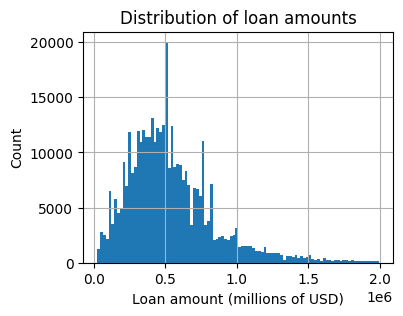

In [57]:
f, ax = plt.subplots(figsize=(4, 3))
df[(df["loan_amount"] > 2e4) & (df["loan_amount"] < 2e6)]["loan_amount"].hist(
    bins=100, ax=ax
)
plt.ylabel("Count")
plt.xlabel("Loan amount (millions of USD)")
plt.title("Distribution of loan amounts")
plt.show()

In [58]:
df = df[(df["loan_amount"] > 2e4) & (df["loan_amount"] < 2e6)]

`property_value`: above 250k and below 

In [59]:
df["property_value"] = pd.to_numeric(df["property_value"])

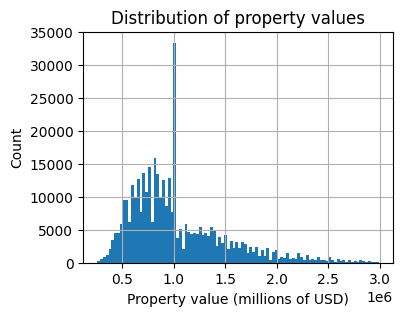

In [60]:
f, ax = plt.subplots(figsize=(4, 3))
df[(df["property_value"] >= 250e3) & (df["property_value"] < 3e6)][
    "property_value"
].hist(bins=100, ax=ax)
plt.ylabel("Count")
plt.xlabel("Property value (millions of USD)")
plt.title("Distribution of property values")
plt.show()

In [61]:
df = df[(df["property_value"] >= 250e3) & (df["property_value"] < 3e6)]

`income`:

- convert to millions of USD
- limiting from above 10k USD and below 1kk USD

In [62]:
df["income"] *= 1000

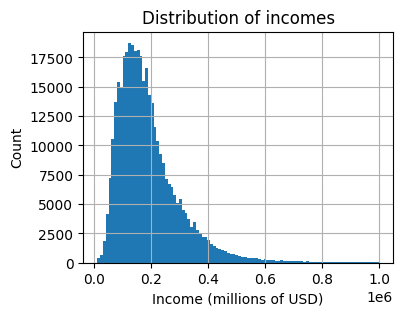

In [63]:
f, ax = plt.subplots(figsize=(4, 3))
df[(df["income"] > 1.0e4) & (df["income"] < 1.0e6)]["income"].hist(bins=100, ax=ax)
plt.ylabel("Count")
plt.xlabel("Income (millions of USD)")
plt.title("Distribution of incomes")
plt.show()

In [64]:
df = df[(df["income"] > 1e4) & (df["income"] < 1e6)]

Other values:

`loan_to_value_ratio`

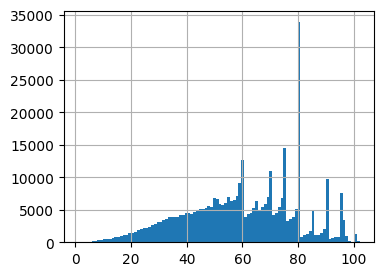

In [65]:
df["loan_to_value_ratio"] = pd.to_numeric(df["loan_to_value_ratio"])
df = df[df["loan_to_value_ratio"] <= 102.0]  # almost all values are <100%

f, ax = plt.subplots(figsize=(4, 3))
df["loan_to_value_ratio"].hist(bins=100, ax=ax)
plt.show()

`debt_to_income_ratio`

debt_to_income_ratio
(0.00154, 0.101]    146962
(0.101, 0.201]      207258
(0.201, 0.3]         23929
(0.3, 0.399]          1076
Name: count, dtype: int64

debt_to_income_ratio
(0.0009400000000000001, 0.0811]    94807
(0.0811, 0.116]                    94807
(0.116, 0.153]                     94820
(0.153, 0.399]                     94791
Name: count, dtype: int64

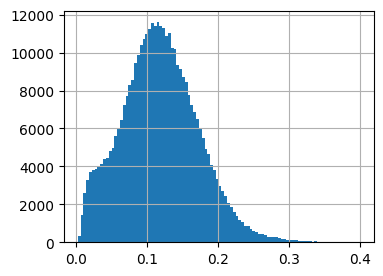

In [66]:
# Redefining the `debt_to_income_ratio` with the values in the dataset
df["debt_to_income_ratio"] = (df["loan_amount"] / (df["loan_term"])) / df["income"]

test_cuts(df, "debt_to_income_ratio", 0.4, n=4)

f, ax = plt.subplots(figsize=(4, 3))
df[df["debt_to_income_ratio"] <= 0.4]["debt_to_income_ratio"].hist(bins=100, ax=ax)
plt.show()

In [67]:
# Removing very large values
df = df[df["debt_to_income_ratio"] < 0.4]

`tract_population`, `tract_to_msa_income_percentage`, `tract_median_age_of_housing_units`

In [68]:
df = df[(df["tract_population"] > 1000) & (df["tract_population"] < 20000)]
df["tract_population"] = pd.to_numeric(df["tract_population"])

In [69]:
df = df[df["tract_to_msa_income_percentage"] > 0]

In [70]:
df["tract_median_age_of_housing_units"] = pd.to_numeric(
    df["tract_median_age_of_housing_units"]
)
df["tract_median_age_of_housing_units"] = (
    df["tract_median_age_of_housing_units"].astype(float) / 10
).astype(int)

In [71]:
for c in [x for x in df.columns if x.startswith("tract") or x.startswith("ffiec")]:
    df[c] = pd.to_numeric(df[c]).astype(float)

In [72]:
# Sorting the columns by dtype
order = {np.dtype('float64'): 0, np.dtype('object'): 1}

df = df[df.dtypes.map(order).sort_values().index]

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 378726 entries, 0 to 492563
Data columns (total 39 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   property_value                     378726 non-null  float64
 1   loan_term                          378726 non-null  float64
 2   rate_spread                        378726 non-null  float64
 3   interest_rate                      378726 non-null  float64
 4   loan_to_value_ratio                378726 non-null  float64
 5   loan_amount                        378726 non-null  float64
 6   debt_to_income_ratio               378726 non-null  float64
 7   tract_population                   378726 non-null  float64
 8   income                             378726 non-null  float64
 9   tract_to_msa_income_percentage     378726 non-null  float64
 10  tract_owner_occupied_units         378726 non-null  float64
 11  tract_one_to_four_family_homes     378726 no

In [74]:
df.reset_index(drop=True).to_csv("../../data-hdma-eastbay-2020-2022-preprocessed.csv")